# Proyecto Inteligencia Artificial
Stefano Aragoni, Luis Diego Santos, Carol Arevalo

______________________

El objetivo del presente proyecto es detectar los tweets que puedan estar relacionados con cyberbulling. Para ello se descargo una base de datos de tweets del 2020. 

---------------
### Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import re

from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC

from nltk.stem import SnowballStemmer
from copy import deepcopy

from pandas.plotting import scatter_matrix
import pandas_profiling

from prettytable import PrettyTable

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_8505/2782784840.py:25: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefanoaragoni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stefanoaragoni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#cargar dataset
data = pd.read_csv('cyberbullying_tweets_clean.csv')

In [3]:
# Imprimir las primeras 5 filas
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
# Imprimir las últimas 5 filas
data.tail()

,tweet_text,cyberbullying_type
39864,"Black ppl aren't expected to do anything, depe...",ethnicity
39865,Turner did not withhold his disappointment. Tu...,ethnicity
39866,I swear to God. This dumb nigger bitch. I have...,ethnicity
39867,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
39868,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


##### Datos Faltantes
En este caso, primero se analizó si hacían falta datos en el dataset. En este caso, todos los datos estaban almacenados y no habían datos fuera de lugar.

Index([], dtype='object')

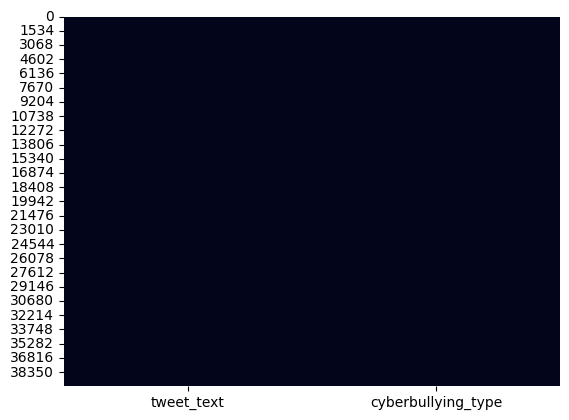

In [5]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

##### Datos Duplicados
Se buscaron datos dupllicados para eliminarlos y tener un modelo más exacto.


In [6]:
data['tweet_text'] = data['tweet_text'].str.lower()

#verificar datos duplicados
data.duplicated().sum()

59

In [7]:
#eliminar datos duplicados
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

##### Distribución de clases
Este tipo de análisis es útil para obtener una mejor comprensión de la distribución de los diferentes tipos de ciberacoso en los datos y para identificar los tipos de ciberacoso más comunes en un conjunto de datos.

In [8]:
# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

religion             7994
age                  7979
ethnicity            7953
gender               7947
not_cyberbullying    7937
Name: cyberbullying_type, dtype: int64


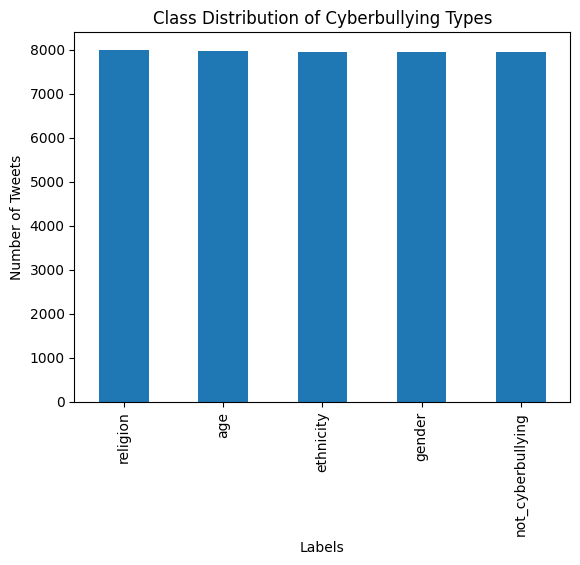

In [9]:
# Create a bar plot of the class distribution
class_counts = data['cyberbullying_type'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Cyberbullying Types')
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

En este caso, se puede comprobar que los datos están balanceados.

--------
### Preprocesamiento de Datos
#### Conteo de palabras 
A continuacion se hace un analisis de las palabras mas comunes de la base de datos. 

In [10]:
# Remover URLs, menciones y hashtags
new_tweets = []
new_types = []

def remove_urls_mentions_hashtags(text, type):
    text = re.sub(r'http\S+', '', text) # URLs
    text = re.sub(r'@\S+', '', text) # Menciones
    text = re.sub(r'#\S+', '', text) # Hashtags

    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub('[^a-zA-Z]', ' ', text) # Puntuación y números

    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text, type

for i in tqdm(range(len(data))):
    try:
        text, type = remove_urls_mentions_hashtags(data['tweet_text'][i], data['cyberbullying_type'][i])
        new_tweets.append(text)
        new_types.append(type)
    except:
        pass

data = pd.DataFrame({
    'tweet_text': new_tweets,
    'cyberbullying_type': new_types
})

100%|██████████| 39810/39810 [00:08<00:00, 4679.82it/s]


In [11]:
# Frecuencia de cada palabra
tweets = ' '.join(data['tweet_text'].values)
words = tweets.split()

frecuencia = Counter(words).most_common(10)

frecuencia

[('school', 8795),
 ('fuck', 5711),
 ('like', 5427),
 ('dumb', 5323),
 ('high', 5218),
 ('bullied', 4489),
 ('people', 4462),
 ('rape', 4408),
 ('nigger', 4407),
 ('u', 4199)]

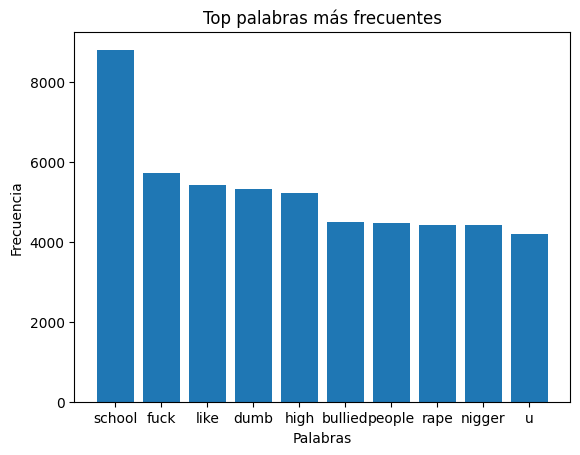

In [12]:
# diagrama de barras
plt.bar(*zip(*frecuencia))
plt.title('Top palabras más frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

#### Preparación de datos para modelos

Ya que se realizó la limpieza del dataset, así como en análisis de las palabras más comunes... se procede a realizar el modelo de Machine Learning.

En este caso, se estará utilizando 2 modelos. Uno de Cyberbullying o no, y otro del tipo de cyberbullying. A continuación se muestra la distribución de clases para cada uno de ellos.

In [13]:
modelo1 = data.__deepcopy__()
modelo2 = data.__deepcopy__()

# Modelo 1: Cyberbullying vs. Not Cyberbullying

# Separate `not_cyberbullying` and `cyberbullying` data
not_cyberbullying = modelo1[modelo1['cyberbullying_type'] == 'not_cyberbullying']
age = modelo1[modelo1['cyberbullying_type'] == 'age']
gender = modelo1[modelo1['cyberbullying_type'] == 'gender']
religion = modelo1[modelo1['cyberbullying_type'] == 'religion']
ethnicity = modelo1[modelo1['cyberbullying_type'] == 'ethnicity']

sample_size = int(len(not_cyberbullying)/4)
sampled_age = age.sample(n=sample_size, replace=True, random_state=42)
sampled_gender = gender.sample(n=sample_size, replace=True, random_state=42)
sampled_religion = religion.sample(n=sample_size, replace=True, random_state=42)
sampled_ethnicity = ethnicity.sample(n=sample_size, replace=True, random_state=42)

# Combine `sampled_cyberbullying` and `not_cyberbullying` data to create a new balanced dataframe
modelo1 = pd.concat([not_cyberbullying, sampled_gender, sampled_age, sampled_ethnicity, sampled_religion])

# Remplazar label age, gender, religion, ethnicity por bullying
modelo1['cyberbullying_type'] = modelo1['cyberbullying_type'].replace(['age', 'gender', 'religion', 'ethnicity'], 'cyberbullying')

# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = modelo1['cyberbullying_type'].value_counts()

# Mostrar los resultados
print("\nModelo 1: Cyberbullying vs. Not Cyberbullying\n")
print(frecuencias)


Modelo 1: Cyberbullying vs. Not Cyberbullying

not_cyberbullying    7937
cyberbullying        7936
Name: cyberbullying_type, dtype: int64


In [14]:
# Modelo 2: Tipos de Cyberbullying

# Separate `not_cyberbullying` and `cyberbullying` data
age = modelo2[modelo2['cyberbullying_type'] == 'age']
gender = modelo2[modelo2['cyberbullying_type'] == 'gender']
religion = modelo2[modelo2['cyberbullying_type'] == 'religion']
ethnicity = modelo2[modelo2['cyberbullying_type'] == 'ethnicity']

# Combine `sampled_cyberbullying` and `not_cyberbullying` data to create a new balanced dataframe
modelo2 = pd.concat([gender, age, ethnicity, religion])

# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = modelo2['cyberbullying_type'].value_counts()

# Mostrar los resultados
print("\nModelo 2: Cyberbullying Type\n")
print(frecuencias)


Modelo 2: Cyberbullying Type

religion     7994
age          7979
gender       7947
ethnicity    7894
Name: cyberbullying_type, dtype: int64


-----------
## Creación de Modelos

En este caso, como primer punto se separó el dataset en tres partes: una para entrenamiento, otra para validación y otra para prueba.

Con esto en mente, se busca poder generar diferentes modelos para poder compararlos y ver cual es el que mejor se ajusta a los datos. Primero se utilizó el set de validación para, a través de GridSearchCV encontrar los mejores parametros. Posteriormente, en creación de modelos se utilizó 80% de los datos para la generación de los mismos. 

Finalmente, se utilizó otro 10% para verificar el funcionamiento correcto de los modelos generados. 


In [15]:
vectorizer1 = CountVectorizer()
X1 = vectorizer1.fit_transform(modelo1['tweet_text']).toarray()
y1 = modelo1['cyberbullying_type']

vectorizer2 = CountVectorizer()
X2 = vectorizer2.fit_transform(modelo2['tweet_text']).toarray()
y2 = modelo2['cyberbullying_type']


In [16]:
# Split modelo1 into train, validation and test sets with a 80-10-10 ratio
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)

# Split modelo2 into train, validation and test sets with a 80-10-10 ratio
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_test2, y_test2, test_size=0.5, random_state=42)


best_models1 = []
best_models2 = []

### Regresion Logistica

In [17]:
# Modelo1: Cyberbullying vs. Not Cyberbullying
param_grid = {
    'C': [0.1, 1],
    'max_iter': [1000],
}

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, cv=5)
clf.fit(X_val1, y_val1)

best_lr1 = LogisticRegression(**clf.best_params_)
best_lr1.fit(X_train1, y_train1)

accuracy = accuracy_score(y_test1, best_lr1.predict(X_test1))
best_models1.append(('Logistic Regression M1', clf.best_params_, accuracy))

print("Regresion Logistica (Bullying vs. Not Bullying): ", accuracy, "\n")

Regresion Logistica (Bullying vs. Not Bullying):  0.9219143576826196 



In [18]:
# Matrix and classification report
print(classification_report(y_test1, best_lr1.predict(X_test1)))

                   precision    recall  f1-score   support

    cyberbullying       0.95      0.90      0.92       792
not_cyberbullying       0.90      0.95      0.92       796

         accuracy                           0.92      1588
        macro avg       0.92      0.92      0.92      1588
     weighted avg       0.92      0.92      0.92      1588



In [19]:
lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, cv=5)
clf.fit(X_val2, y_val2)

best_lr2 = LogisticRegression(**clf.best_params_)
best_lr2.fit(X_train2, y_train2)

accuracy = accuracy_score(y_test2, best_lr2.predict(X_test2))
best_models2.append(('Logistic Regression M2', clf.best_params_, accuracy))

print("Regresion Logistica (Type of Bullying) : ", accuracy, "\n")

Regresion Logistica (Type of Bullying) :  0.9817724701445631 



In [20]:
# Matrix and classification report
print(classification_report(y_test2, best_lr2.predict(X_test2)))

              precision    recall  f1-score   support

         age       0.99      0.99      0.99       817
   ethnicity       0.99      0.98      0.99       795
      gender       0.96      0.98      0.97       801
    religion       0.99      0.97      0.98       769

    accuracy                           0.98      3182
   macro avg       0.98      0.98      0.98      3182
weighted avg       0.98      0.98      0.98      3182

